In [9]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.17
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [1]:
import pandas as pd

In [2]:
import numpy as np
import random
import os
import gc

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [5]:
train['City'] = [(i.split(',')[0]).lstrip().title() for i in train['Location']]
train['State'] = [(i.split(',')[1]).lstrip().title() for i in train['Location']]
train['Country'] = [(i.split(',')[2]).lstrip().title() for i in train['Location']]

In [6]:
test['City'] = [(i.split(',')[0]).lstrip().title() for i in test['Location']]
test['State'] = [(i.split(',')[1]).lstrip().title() for i in test['Location']]
test['Country'] = [(i.split(',')[2]).lstrip().title() for i in test['Location']]

In [20]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [7]:
# 나이 그룹화
labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
train['Age_gb'] = pd.cut(train.Age, bins, labels = labels,include_lowest = True)

In [8]:
test['Age_gb'] = pd.cut(test.Age, bins, labels = labels,include_lowest = True)

In [9]:
from sklearn.preprocessing import OrdinalEncoder

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

In [10]:
X_train = train_lb.drop(columns = ['ID','Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID'])

In [11]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

In [14]:
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

sampler = TPESampler(seed = 113)
def objective(trial):
    FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']
    train_x, test_x, train_y, test_y = train_test_split(X_train[FEATURE], y_train, test_size=0.2,random_state=42)
    param = {
        'tree_method':'gpu_hist',
        'gpu_id':0,
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 25000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [113]),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 300),
        'eval_metric' : 'rmse',
        'early_stopping_rounds' : 100
    }
    model =XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], verbose=False)
    
    preds = np.clip(model.predict(test_x[FEATURE]),0,10)
    
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse
          
study_xgb = optuna.create_study(
    direction='minimize',
    study_name = 'Xgboost Optuna', 
    sampler=sampler
)
study_xgb.optimize(objective, n_trials=1000, timeout = 3600*1)

[I 2023-04-28 11:07:25,842] A new study created in memory with name: Xgboost Optuna
[I 2023-04-28 11:08:35,492] Trial 0 finished with value: 3.432492487684231 and parameters: {'lambda': 0.08534656378027873, 'alpha': 0.07482969524341769, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 17000, 'max_depth': 13, 'random_state': 113, 'min_child_weight': 84}. Best is trial 0 with value: 3.432492487684231.
[I 2023-04-28 11:09:11,148] Trial 1 finished with value: 3.430621570940563 and parameters: {'lambda': 0.053046496177405235, 'alpha': 0.2600977536747163, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 2991, 'max_depth': 11, 'random_state': 113, 'min_child_weight': 206}. Best is trial 1 with value: 3.430621570940563.
[I 2023-04-28 11:09:54,705] Trial 2 finished with value: 3.4801014418334204 and parameters: {'lambda': 0.08386773236732104, 'alpha': 0.7738470945799337, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate'

In [12]:
trial_xgb = study_xgb.best_trial
xgb_params = trial_xgb.params

NameError: name 'study_xgb' is not defined

In [13]:
xgb_params = {'lambda': 0.05576344920852407, 'alpha': 0.28724065047316105, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 7488, 'max_depth': 15, 'random_state': 113, 'min_child_weight': 3}

In [14]:
xgb_params['random_state'] = 113
xgb_params['tree_method'] = 'gpu_hist'
xgb_params['eval_metric'] = 'rmse'
xgb_params['gpu_id'] = 0

In [18]:
from cuml.ensemble import RandomForestRegressor as curfr
from xgboost import XGBRegressor

model2 = curfr(n_streams=1, n_estimators = 3000 , random_state=113 )
model3 = XGBRegressor(**xgb_params)
#other catboost
model4 = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 17.178091468605494,
                          max_bin = 348,
                          learning_rate = 0.007058948631189331,
                          max_depth = 11,
                          min_data_in_leaf = 118,
                          iterations = 24635,
                          subsample = 0.9984770090737676,
                          eval_metric = 'RMSE',
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          verbose=500
                          )
model5 = curfr(n_streams=1 , n_estimators = 1000, max_depth=9, random_state=113)

In [20]:
!pip install mlxtend  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.1 MB/s eta 0:00:00a 0:00:01


In [19]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
strg = StackingCVRegressor(regressors =[model, model4, model5, model3], meta_regressor = model, cv=10, random_state = 113, use_features_in_secondary= True)

strg_fit = strg.fit(X_train[FEATURE], y_train)

0:	learn: 3.8456652	total: 21.3ms	remaining: 3m 5s
500:	learn: 3.6699327	total: 9.75s	remaining: 2m 39s
1000:	learn: 3.6114965	total: 20.5s	remaining: 2m 37s
1500:	learn: 3.5758382	total: 30.2s	remaining: 2m 24s
2000:	learn: 3.5458200	total: 39.3s	remaining: 2m 11s
2500:	learn: 3.5211443	total: 48.4s	remaining: 1m 59s
3000:	learn: 3.4993095	total: 57.4s	remaining: 1m 48s
3500:	learn: 3.4792654	total: 1m 6s	remaining: 1m 38s
4000:	learn: 3.4609451	total: 1m 15s	remaining: 1m 28s
4500:	learn: 3.4441147	total: 1m 24s	remaining: 1m 18s
5000:	learn: 3.4278869	total: 1m 33s	remaining: 1m 9s
5500:	learn: 3.4125309	total: 1m 42s	remaining: 59.8s
6000:	learn: 3.3980994	total: 1m 52s	remaining: 50.3s
6500:	learn: 3.3843363	total: 2m 1s	remaining: 40.9s
7000:	learn: 3.3707378	total: 2m 10s	remaining: 31.5s
7500:	learn: 3.3577009	total: 2m 19s	remaining: 22.2s
8000:	learn: 3.3450640	total: 2m 28s	remaining: 12.9s
8500:	learn: 3.3329339	total: 2m 37s	remaining: 3.58s
8693:	learn: 3.3282412	total: 2

0:	learn: 3.8446155	total: 18.2ms	remaining: 2m 38s
500:	learn: 3.6669310	total: 9.04s	remaining: 2m 27s
1000:	learn: 3.6109942	total: 18s	remaining: 2m 18s
1500:	learn: 3.5734639	total: 27.1s	remaining: 2m 9s
2000:	learn: 3.5438842	total: 36.1s	remaining: 2m
2500:	learn: 3.5184769	total: 45.2s	remaining: 1m 51s
3000:	learn: 3.4958815	total: 54.2s	remaining: 1m 42s
3500:	learn: 3.4763108	total: 1m 3s	remaining: 1m 33s
4000:	learn: 3.4577442	total: 1m 12s	remaining: 1m 24s
4500:	learn: 3.4408287	total: 1m 21s	remaining: 1m 15s
5000:	learn: 3.4247839	total: 1m 30s	remaining: 1m 6s
5500:	learn: 3.4097868	total: 1m 39s	remaining: 57.9s
6000:	learn: 3.3953351	total: 1m 48s	remaining: 48.9s
6500:	learn: 3.3815549	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3680524	total: 2m 7s	remaining: 30.9s
7500:	learn: 3.3549135	total: 2m 17s	remaining: 21.8s
8000:	learn: 3.3422010	total: 2m 26s	remaining: 12.7s
8500:	learn: 3.3299362	total: 2m 35s	remaining: 3.53s
8693:	learn: 3.3253695	total: 2m 39s	

0:	learn: 3.8456365	total: 18.1ms	remaining: 2m 37s
500:	learn: 3.6683048	total: 9.05s	remaining: 2m 28s
1000:	learn: 3.6132641	total: 18s	remaining: 2m 18s
1500:	learn: 3.5758193	total: 27s	remaining: 2m 9s
2000:	learn: 3.5468625	total: 36.1s	remaining: 2m
2500:	learn: 3.5204259	total: 45.1s	remaining: 1m 51s
3000:	learn: 3.4979151	total: 54.1s	remaining: 1m 42s
3500:	learn: 3.4781304	total: 1m 3s	remaining: 1m 33s
4000:	learn: 3.4596707	total: 1m 12s	remaining: 1m 24s
4500:	learn: 3.4426109	total: 1m 21s	remaining: 1m 15s
5000:	learn: 3.4265905	total: 1m 30s	remaining: 1m 6s
5500:	learn: 3.4111524	total: 1m 39s	remaining: 57.7s
6000:	learn: 3.3964970	total: 1m 48s	remaining: 48.7s
6500:	learn: 3.3827236	total: 1m 57s	remaining: 39.7s
7000:	learn: 3.3692086	total: 2m 6s	remaining: 30.7s
7500:	learn: 3.3561787	total: 2m 15s	remaining: 21.6s
8000:	learn: 3.3433444	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3307100	total: 2m 34s	remaining: 3.5s
8693:	learn: 3.3259601	total: 2m 37s	rem

0:	learn: 3.8441366	total: 39.3ms	remaining: 5m 41s
500:	learn: 3.6697492	total: 9.17s	remaining: 2m 30s
1000:	learn: 3.6119507	total: 18.2s	remaining: 2m 19s
1500:	learn: 3.5742016	total: 27.2s	remaining: 2m 10s
2000:	learn: 3.5447263	total: 36.3s	remaining: 2m 1s
2500:	learn: 3.5192017	total: 45.3s	remaining: 1m 52s
3000:	learn: 3.4968124	total: 54.4s	remaining: 1m 43s
3500:	learn: 3.4769484	total: 1m 3s	remaining: 1m 34s
4000:	learn: 3.4590409	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4419554	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4260235	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4106947	total: 1m 40s	remaining: 58.1s
6000:	learn: 3.3963400	total: 1m 49s	remaining: 49s
6500:	learn: 3.3824359	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3688684	total: 2m 7s	remaining: 30.9s
7500:	learn: 3.3557563	total: 2m 16s	remaining: 21.8s
8000:	learn: 3.3431824	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3308411	total: 2m 35s	remaining: 3.52s
8693:	learn: 3.3261167	total: 2m 

0:	learn: 3.8446578	total: 18.3ms	remaining: 2m 38s
500:	learn: 3.6684496	total: 9.08s	remaining: 2m 28s
1000:	learn: 3.6125778	total: 18.1s	remaining: 2m 19s
1500:	learn: 3.5745159	total: 27.1s	remaining: 2m 10s
2000:	learn: 3.5450650	total: 36.2s	remaining: 2m 1s
2500:	learn: 3.5210480	total: 45.3s	remaining: 1m 52s
3000:	learn: 3.4985405	total: 54.4s	remaining: 1m 43s
3500:	learn: 3.4787920	total: 1m 3s	remaining: 1m 34s
4000:	learn: 3.4600143	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4432079	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4270084	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4117348	total: 1m 40s	remaining: 58.1s
6000:	learn: 3.3973174	total: 1m 49s	remaining: 49s
6500:	learn: 3.3835719	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3699481	total: 2m 7s	remaining: 30.9s
7500:	learn: 3.3566398	total: 2m 16s	remaining: 21.8s
8000:	learn: 3.3438866	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3316740	total: 2m 35s	remaining: 3.52s
8693:	learn: 3.3269914	total: 2m 

0:	learn: 3.8449684	total: 18.1ms	remaining: 2m 36s
500:	learn: 3.6692559	total: 9.04s	remaining: 2m 27s
1000:	learn: 3.6130498	total: 18s	remaining: 2m 18s
1500:	learn: 3.5748630	total: 27.1s	remaining: 2m 9s
2000:	learn: 3.5458271	total: 36.1s	remaining: 2m
2500:	learn: 3.5208041	total: 45.2s	remaining: 1m 51s
3000:	learn: 3.4988982	total: 54.3s	remaining: 1m 42s
3500:	learn: 3.4785618	total: 1m 3s	remaining: 1m 33s
4000:	learn: 3.4602588	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4430568	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4268554	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4117669	total: 1m 39s	remaining: 58s
6000:	learn: 3.3974653	total: 1m 49s	remaining: 48.9s
6500:	learn: 3.3835495	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3701055	total: 2m 7s	remaining: 30.8s
7500:	learn: 3.3570312	total: 2m 16s	remaining: 21.7s
8000:	learn: 3.3442931	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3321026	total: 2m 35s	remaining: 3.52s
8693:	learn: 3.3274952	total: 2m 38s	re

0:	learn: 3.8449944	total: 18.4ms	remaining: 2m 39s
500:	learn: 3.6678968	total: 9.05s	remaining: 2m 27s
1000:	learn: 3.6094732	total: 18.1s	remaining: 2m 18s
1500:	learn: 3.5722245	total: 27.1s	remaining: 2m 10s
2000:	learn: 3.5427353	total: 36.2s	remaining: 2m 1s
2500:	learn: 3.5175345	total: 45.3s	remaining: 1m 52s
3000:	learn: 3.4958669	total: 54.3s	remaining: 1m 43s
3500:	learn: 3.4760278	total: 1m 3s	remaining: 1m 34s
4000:	learn: 3.4580012	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4411270	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4255534	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4105253	total: 1m 39s	remaining: 58s
6000:	learn: 3.3959711	total: 1m 49s	remaining: 49s
6500:	learn: 3.3820495	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3688088	total: 2m 7s	remaining: 30.8s
7500:	learn: 3.3557726	total: 2m 16s	remaining: 21.7s
8000:	learn: 3.3430995	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3306920	total: 2m 35s	remaining: 3.52s
8693:	learn: 3.3260113	total: 2m 38

0:	learn: 3.8454253	total: 18.1ms	remaining: 2m 37s
500:	learn: 3.6682762	total: 9.07s	remaining: 2m 28s
1000:	learn: 3.6117959	total: 18.1s	remaining: 2m 19s
1500:	learn: 3.5756603	total: 27.2s	remaining: 2m 10s
2000:	learn: 3.5464560	total: 36.2s	remaining: 2m 1s
2500:	learn: 3.5216993	total: 45.3s	remaining: 1m 52s
3000:	learn: 3.4993140	total: 54.4s	remaining: 1m 43s
3500:	learn: 3.4794436	total: 1m 3s	remaining: 1m 34s
4000:	learn: 3.4614108	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4444877	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4286278	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4136911	total: 1m 40s	remaining: 58.1s
6000:	learn: 3.3990336	total: 1m 49s	remaining: 49s
6500:	learn: 3.3851048	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3715492	total: 2m 7s	remaining: 30.9s
7500:	learn: 3.3586320	total: 2m 16s	remaining: 21.8s
8000:	learn: 3.3459781	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3336624	total: 2m 35s	remaining: 3.52s
8693:	learn: 3.3289872	total: 2m 

0:	learn: 3.8454804	total: 36.5ms	remaining: 5m 16s
500:	learn: 3.6677916	total: 9.16s	remaining: 2m 29s
1000:	learn: 3.6126966	total: 18.2s	remaining: 2m 19s
1500:	learn: 3.5753921	total: 27.3s	remaining: 2m 10s
2000:	learn: 3.5461764	total: 36.3s	remaining: 2m 1s
2500:	learn: 3.5210678	total: 45.4s	remaining: 1m 52s
3000:	learn: 3.4987550	total: 54.5s	remaining: 1m 43s
3500:	learn: 3.4784253	total: 1m 3s	remaining: 1m 34s
4000:	learn: 3.4602426	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4434866	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4272188	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4120338	total: 1m 39s	remaining: 58s
6000:	learn: 3.3974614	total: 1m 49s	remaining: 48.9s
6500:	learn: 3.3833396	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3699288	total: 2m 7s	remaining: 30.8s
7500:	learn: 3.3568271	total: 2m 16s	remaining: 21.7s
8000:	learn: 3.3442675	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3317745	total: 2m 34s	remaining: 3.52s
8693:	learn: 3.3271052	total: 2m 

0:	learn: 3.8469974	total: 18.6ms	remaining: 2m 41s
500:	learn: 3.6711278	total: 9.04s	remaining: 2m 27s
1000:	learn: 3.6137186	total: 18s	remaining: 2m 18s
1500:	learn: 3.5764051	total: 27.1s	remaining: 2m 9s
2000:	learn: 3.5465660	total: 36.2s	remaining: 2m 1s
2500:	learn: 3.5210555	total: 45.3s	remaining: 1m 52s
3000:	learn: 3.4991448	total: 54.3s	remaining: 1m 43s
3500:	learn: 3.4791611	total: 1m 3s	remaining: 1m 34s
4000:	learn: 3.4609945	total: 1m 12s	remaining: 1m 25s
4500:	learn: 3.4436064	total: 1m 21s	remaining: 1m 16s
5000:	learn: 3.4277547	total: 1m 30s	remaining: 1m 7s
5500:	learn: 3.4125431	total: 1m 40s	remaining: 58s
6000:	learn: 3.3979072	total: 1m 49s	remaining: 49s
6500:	learn: 3.3839851	total: 1m 58s	remaining: 39.9s
7000:	learn: 3.3706730	total: 2m 7s	remaining: 30.8s
7500:	learn: 3.3576127	total: 2m 16s	remaining: 21.7s
8000:	learn: 3.3450207	total: 2m 25s	remaining: 12.6s
8500:	learn: 3.3329559	total: 2m 35s	remaining: 3.52s
8693:	learn: 3.3283467	total: 2m 38s	r

0:	learn: 3.8461174	total: 18.3ms	remaining: 7m 30s
500:	learn: 3.6922904	total: 9.14s	remaining: 7m 20s
1000:	learn: 3.6416925	total: 18.3s	remaining: 7m 11s
1500:	learn: 3.6097800	total: 27.4s	remaining: 7m 1s
2000:	learn: 3.5847058	total: 36.4s	remaining: 6m 52s
2500:	learn: 3.5647237	total: 45.6s	remaining: 6m 43s
3000:	learn: 3.5476079	total: 54.7s	remaining: 6m 34s
3500:	learn: 3.5318996	total: 1m 3s	remaining: 6m 25s
4000:	learn: 3.5178485	total: 1m 12s	remaining: 6m 16s
4500:	learn: 3.5055555	total: 1m 22s	remaining: 6m 7s
5000:	learn: 3.4940705	total: 1m 31s	remaining: 5m 58s
5500:	learn: 3.4834294	total: 1m 40s	remaining: 5m 49s
6000:	learn: 3.4738296	total: 1m 49s	remaining: 5m 40s
6500:	learn: 3.4647494	total: 1m 58s	remaining: 5m 31s
7000:	learn: 3.4560434	total: 2m 8s	remaining: 5m 22s
7500:	learn: 3.4477186	total: 2m 17s	remaining: 5m 13s
8000:	learn: 3.4397775	total: 2m 26s	remaining: 5m 4s
8500:	learn: 3.4318683	total: 2m 35s	remaining: 4m 55s
9000:	learn: 3.4245776	to

0:	learn: 3.8450371	total: 18.3ms	remaining: 7m 30s
500:	learn: 3.6926449	total: 9.2s	remaining: 7m 23s
1000:	learn: 3.6412345	total: 18.3s	remaining: 7m 11s
1500:	learn: 3.6083813	total: 27.4s	remaining: 7m 2s
2000:	learn: 3.5842889	total: 36.5s	remaining: 6m 53s
2500:	learn: 3.5641875	total: 45.7s	remaining: 6m 44s
3000:	learn: 3.5470448	total: 54.9s	remaining: 6m 35s
3500:	learn: 3.5313503	total: 1m 4s	remaining: 6m 26s
4000:	learn: 3.5174988	total: 1m 13s	remaining: 6m 17s
4500:	learn: 3.5045482	total: 1m 22s	remaining: 6m 8s
5000:	learn: 3.4930965	total: 1m 31s	remaining: 5m 59s
5500:	learn: 3.4824657	total: 1m 40s	remaining: 5m 50s
6000:	learn: 3.4725050	total: 1m 49s	remaining: 5m 41s
6500:	learn: 3.4632936	total: 1m 59s	remaining: 5m 32s
7000:	learn: 3.4545457	total: 2m 8s	remaining: 5m 23s
7500:	learn: 3.4461644	total: 2m 17s	remaining: 5m 14s
8000:	learn: 3.4382648	total: 2m 26s	remaining: 5m 5s
8500:	learn: 3.4307263	total: 2m 36s	remaining: 4m 56s
9000:	learn: 3.4235489	tot

0:	learn: 3.8460815	total: 18.8ms	remaining: 7m 42s
500:	learn: 3.6905841	total: 9.12s	remaining: 7m 19s
1000:	learn: 3.6423080	total: 18.2s	remaining: 7m 10s
1500:	learn: 3.6099439	total: 27.4s	remaining: 7m 1s
2000:	learn: 3.5860871	total: 36.6s	remaining: 6m 53s
2500:	learn: 3.5655063	total: 45.7s	remaining: 6m 44s
3000:	learn: 3.5480559	total: 54.9s	remaining: 6m 35s
3500:	learn: 3.5321101	total: 1m 4s	remaining: 6m 26s
4000:	learn: 3.5180005	total: 1m 13s	remaining: 6m 17s
4500:	learn: 3.5053036	total: 1m 22s	remaining: 6m 8s
5000:	learn: 3.4940199	total: 1m 31s	remaining: 5m 59s
5500:	learn: 3.4834820	total: 1m 40s	remaining: 5m 50s
6000:	learn: 3.4737584	total: 1m 49s	remaining: 5m 41s
6500:	learn: 3.4644643	total: 1m 59s	remaining: 5m 32s
7000:	learn: 3.4558005	total: 2m 8s	remaining: 5m 23s
7500:	learn: 3.4476106	total: 2m 17s	remaining: 5m 14s
8000:	learn: 3.4396682	total: 2m 26s	remaining: 5m 5s
8500:	learn: 3.4321384	total: 2m 36s	remaining: 4m 56s
9000:	learn: 3.4249256	to

0:	learn: 3.8445500	total: 18.3ms	remaining: 7m 30s
500:	learn: 3.6934702	total: 9.32s	remaining: 7m 29s
1000:	learn: 3.6434720	total: 19.2s	remaining: 7m 32s
1500:	learn: 3.6078869	total: 28.7s	remaining: 7m 22s
2000:	learn: 3.5834998	total: 38.1s	remaining: 7m 11s
2500:	learn: 3.5629953	total: 47.6s	remaining: 7m
3000:	learn: 3.5460581	total: 57s	remaining: 6m 50s
3500:	learn: 3.5309579	total: 1m 6s	remaining: 6m 40s
4000:	learn: 3.5173206	total: 1m 16s	remaining: 6m 32s
4500:	learn: 3.5043835	total: 1m 25s	remaining: 6m 24s
5000:	learn: 3.4928747	total: 1m 35s	remaining: 6m 15s
5500:	learn: 3.4818939	total: 1m 45s	remaining: 6m 6s
6000:	learn: 3.4720673	total: 1m 55s	remaining: 5m 58s
6500:	learn: 3.4625203	total: 2m 5s	remaining: 5m 49s
7000:	learn: 3.4538093	total: 2m 14s	remaining: 5m 39s
7500:	learn: 3.4458097	total: 2m 24s	remaining: 5m 30s
8000:	learn: 3.4378218	total: 2m 34s	remaining: 5m 21s
8500:	learn: 3.4302877	total: 2m 43s	remaining: 5m 10s
9000:	learn: 3.4228550	total:

0:	learn: 3.8451159	total: 22.8ms	remaining: 9m 21s
500:	learn: 3.6934462	total: 10.3s	remaining: 8m 17s
1000:	learn: 3.6433792	total: 20.8s	remaining: 8m 10s
1500:	learn: 3.6098268	total: 30.5s	remaining: 7m 50s
2000:	learn: 3.5837416	total: 40.3s	remaining: 7m 35s
2500:	learn: 3.5640949	total: 50.1s	remaining: 7m 23s
3000:	learn: 3.5464666	total: 59.8s	remaining: 7m 10s
3500:	learn: 3.5311236	total: 1m 9s	remaining: 6m 58s
4000:	learn: 3.5179031	total: 1m 18s	remaining: 6m 46s
4500:	learn: 3.5050444	total: 1m 28s	remaining: 6m 35s
5000:	learn: 3.4936542	total: 1m 38s	remaining: 6m 24s
5500:	learn: 3.4831743	total: 1m 47s	remaining: 6m 14s
6000:	learn: 3.4737490	total: 1m 57s	remaining: 6m 4s
6500:	learn: 3.4646684	total: 2m 6s	remaining: 5m 53s
7000:	learn: 3.4561552	total: 2m 16s	remaining: 5m 45s
7500:	learn: 3.4476876	total: 2m 27s	remaining: 5m 36s
8000:	learn: 3.4397833	total: 2m 37s	remaining: 5m 28s
8500:	learn: 3.4320056	total: 2m 48s	remaining: 5m 19s
9000:	learn: 3.4246382	

0:	learn: 3.8453776	total: 18ms	remaining: 7m 23s
500:	learn: 3.6920628	total: 9.13s	remaining: 7m 19s
1000:	learn: 3.6444915	total: 18.2s	remaining: 7m 9s
1500:	learn: 3.6105767	total: 27.3s	remaining: 7m
2000:	learn: 3.5857879	total: 36.3s	remaining: 6m 51s
2500:	learn: 3.5656930	total: 45.4s	remaining: 6m 42s
3000:	learn: 3.5481932	total: 54.5s	remaining: 6m 33s
3500:	learn: 3.5330841	total: 1m 3s	remaining: 6m 24s
4000:	learn: 3.5194680	total: 1m 12s	remaining: 6m 15s
4500:	learn: 3.5069321	total: 1m 21s	remaining: 6m 6s
5000:	learn: 3.4952646	total: 1m 30s	remaining: 5m 57s
5500:	learn: 3.4844183	total: 1m 40s	remaining: 5m 48s
6000:	learn: 3.4746009	total: 1m 49s	remaining: 5m 39s
6500:	learn: 3.4654898	total: 1m 58s	remaining: 5m 30s
7000:	learn: 3.4567268	total: 2m 7s	remaining: 5m 21s
7500:	learn: 3.4484946	total: 2m 16s	remaining: 5m 12s
8000:	learn: 3.4408076	total: 2m 26s	remaining: 5m 3s
8500:	learn: 3.4333514	total: 2m 35s	remaining: 4m 54s
9000:	learn: 3.4259244	total: 2

0:	learn: 3.8454971	total: 18.2ms	remaining: 7m 27s
500:	learn: 3.6930260	total: 9.1s	remaining: 7m 18s
1000:	learn: 3.6420433	total: 18.2s	remaining: 7m 9s
1500:	learn: 3.6085172	total: 27.3s	remaining: 7m
2000:	learn: 3.5839458	total: 36.4s	remaining: 6m 51s
2500:	learn: 3.5633802	total: 45.5s	remaining: 6m 42s
3000:	learn: 3.5455926	total: 54.6s	remaining: 6m 33s
3500:	learn: 3.5299833	total: 1m 3s	remaining: 6m 24s
4000:	learn: 3.5162963	total: 1m 12s	remaining: 6m 15s
4500:	learn: 3.5038753	total: 1m 21s	remaining: 6m 6s
5000:	learn: 3.4922431	total: 1m 31s	remaining: 5m 57s
5500:	learn: 3.4813837	total: 1m 40s	remaining: 5m 48s
6000:	learn: 3.4714170	total: 1m 49s	remaining: 5m 39s
6500:	learn: 3.4624062	total: 1m 58s	remaining: 5m 30s
7000:	learn: 3.4540081	total: 2m 7s	remaining: 5m 21s
7500:	learn: 3.4458919	total: 2m 16s	remaining: 5m 12s
8000:	learn: 3.4381649	total: 2m 26s	remaining: 5m 3s
8500:	learn: 3.4306074	total: 2m 35s	remaining: 4m 54s
9000:	learn: 3.4231748	total: 

0:	learn: 3.8458937	total: 18.4ms	remaining: 7m 34s
500:	learn: 3.6921519	total: 9.13s	remaining: 7m 19s
1000:	learn: 3.6429225	total: 18.2s	remaining: 7m 10s
1500:	learn: 3.6107421	total: 27.3s	remaining: 7m
2000:	learn: 3.5859780	total: 36.4s	remaining: 6m 52s
2500:	learn: 3.5655237	total: 45.6s	remaining: 6m 43s
3000:	learn: 3.5491502	total: 54.7s	remaining: 6m 34s
3500:	learn: 3.5337531	total: 1m 3s	remaining: 6m 25s
4000:	learn: 3.5199274	total: 1m 12s	remaining: 6m 16s
4500:	learn: 3.5075716	total: 1m 22s	remaining: 6m 7s
5000:	learn: 3.4963056	total: 1m 31s	remaining: 5m 58s
5500:	learn: 3.4856907	total: 1m 40s	remaining: 5m 49s
6000:	learn: 3.4760336	total: 1m 49s	remaining: 5m 40s
6500:	learn: 3.4668983	total: 1m 58s	remaining: 5m 31s
7000:	learn: 3.4581893	total: 2m 8s	remaining: 5m 22s
7500:	learn: 3.4501722	total: 2m 17s	remaining: 5m 13s
8000:	learn: 3.4423027	total: 2m 26s	remaining: 5m 4s
8500:	learn: 3.4346879	total: 2m 35s	remaining: 4m 55s
9000:	learn: 3.4273140	total

0:	learn: 3.8458539	total: 18.1ms	remaining: 7m 26s
500:	learn: 3.6920643	total: 9.15s	remaining: 7m 20s
1000:	learn: 3.6419031	total: 18.2s	remaining: 7m 10s
1500:	learn: 3.6092127	total: 27.3s	remaining: 7m
2000:	learn: 3.5844636	total: 36.4s	remaining: 6m 52s
2500:	learn: 3.5646529	total: 45.5s	remaining: 6m 43s
3000:	learn: 3.5467461	total: 54.7s	remaining: 6m 34s
3500:	learn: 3.5316512	total: 1m 3s	remaining: 6m 25s
4000:	learn: 3.5175366	total: 1m 12s	remaining: 6m 15s
4500:	learn: 3.5053012	total: 1m 22s	remaining: 6m 6s
5000:	learn: 3.4937445	total: 1m 31s	remaining: 5m 57s
5500:	learn: 3.4830760	total: 1m 40s	remaining: 5m 48s
6000:	learn: 3.4731017	total: 1m 49s	remaining: 5m 39s
6500:	learn: 3.4637322	total: 1m 58s	remaining: 5m 30s
7000:	learn: 3.4552143	total: 2m 7s	remaining: 5m 22s
7500:	learn: 3.4469924	total: 2m 17s	remaining: 5m 13s
8000:	learn: 3.4389636	total: 2m 26s	remaining: 5m 4s
8500:	learn: 3.4314088	total: 2m 35s	remaining: 4m 55s
9000:	learn: 3.4239087	total

0:	learn: 3.8474362	total: 18.3ms	remaining: 7m 31s
500:	learn: 3.6949730	total: 9.08s	remaining: 7m 17s
1000:	learn: 3.6444105	total: 18.1s	remaining: 7m 8s
1500:	learn: 3.6120705	total: 27.2s	remaining: 6m 59s
2000:	learn: 3.5871724	total: 36.3s	remaining: 6m 51s
2500:	learn: 3.5663622	total: 45.5s	remaining: 6m 42s
3000:	learn: 3.5489546	total: 54.6s	remaining: 6m 33s
3500:	learn: 3.5331560	total: 1m 3s	remaining: 6m 24s
4000:	learn: 3.5190930	total: 1m 12s	remaining: 6m 15s
4500:	learn: 3.5064491	total: 1m 21s	remaining: 6m 6s
5000:	learn: 3.4949744	total: 1m 31s	remaining: 5m 57s
5500:	learn: 3.4843140	total: 1m 40s	remaining: 5m 48s
6000:	learn: 3.4743225	total: 1m 49s	remaining: 5m 39s
6500:	learn: 3.4651393	total: 1m 58s	remaining: 5m 30s
7000:	learn: 3.4566127	total: 2m 7s	remaining: 5m 22s
7500:	learn: 3.4485357	total: 2m 17s	remaining: 5m 13s
8000:	learn: 3.4406406	total: 2m 26s	remaining: 5m 4s
8500:	learn: 3.4330359	total: 2m 35s	remaining: 4m 55s
9000:	learn: 3.4256560	to

/home/chunbae/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


0:	learn: 3.8383767	total: 46.5ms	remaining: 6m 44s
500:	learn: 3.3372627	total: 9.66s	remaining: 2m 38s
1000:	learn: 3.3158972	total: 19.9s	remaining: 2m 32s
1500:	learn: 3.2922130	total: 30s	remaining: 2m 23s
2000:	learn: 3.2701456	total: 40.1s	remaining: 2m 14s
2500:	learn: 3.2487193	total: 50.3s	remaining: 2m 4s
3000:	learn: 3.2288275	total: 1m	remaining: 1m 54s
3500:	learn: 3.2096658	total: 1m 10s	remaining: 1m 44s
4000:	learn: 3.1915867	total: 1m 20s	remaining: 1m 34s
4500:	learn: 3.1738238	total: 1m 30s	remaining: 1m 24s
5000:	learn: 3.1566335	total: 1m 40s	remaining: 1m 14s
5500:	learn: 3.1399400	total: 1m 51s	remaining: 1m 4s
6000:	learn: 3.1238404	total: 2m 1s	remaining: 54.4s
6500:	learn: 3.1077573	total: 2m 11s	remaining: 44.3s
7000:	learn: 3.0921851	total: 2m 21s	remaining: 34.2s
7500:	learn: 3.0765768	total: 2m 31s	remaining: 24.1s
8000:	learn: 3.0614301	total: 2m 41s	remaining: 14s
8500:	learn: 3.0469411	total: 2m 51s	remaining: 3.9s
8693:	learn: 3.0413896	total: 2m 55s	

0:	learn: 3.8452753	total: 18.4ms	remaining: 2m 40s
500:	learn: 3.6705687	total: 9.5s	remaining: 2m 35s
1000:	learn: 3.6120052	total: 18.9s	remaining: 2m 25s
1500:	learn: 3.5747340	total: 28.4s	remaining: 2m 16s
2000:	learn: 3.5462585	total: 37.9s	remaining: 2m 6s
2500:	learn: 3.5214570	total: 47.4s	remaining: 1m 57s
3000:	learn: 3.5002764	total: 56.9s	remaining: 1m 47s
3500:	learn: 3.4811718	total: 1m 6s	remaining: 1m 38s
4000:	learn: 3.4636292	total: 1m 15s	remaining: 1m 29s
4500:	learn: 3.4474322	total: 1m 25s	remaining: 1m 19s
5000:	learn: 3.4323005	total: 1m 35s	remaining: 1m 10s
5500:	learn: 3.4177959	total: 1m 44s	remaining: 1m
6000:	learn: 3.4038599	total: 1m 54s	remaining: 51.3s
6500:	learn: 3.3905816	total: 2m 3s	remaining: 41.8s
7000:	learn: 3.3779073	total: 2m 13s	remaining: 32.3s
7500:	learn: 3.3654281	total: 2m 22s	remaining: 22.7s
8000:	learn: 3.3536313	total: 2m 32s	remaining: 13.2s
8500:	learn: 3.3419162	total: 2m 42s	remaining: 3.68s
8693:	learn: 3.3374799	total: 2m 4

0:	learn: 3.8457006	total: 18.6ms	remaining: 7m 36s
500:	learn: 3.6918854	total: 9.53s	remaining: 7m 39s
1000:	learn: 3.6429677	total: 19s	remaining: 7m 29s
1500:	learn: 3.6088971	total: 28.5s	remaining: 7m 19s
2000:	learn: 3.5846660	total: 38s	remaining: 7m 10s
2500:	learn: 3.5647605	total: 47.6s	remaining: 7m
3000:	learn: 3.5474820	total: 57.1s	remaining: 6m 51s
3500:	learn: 3.5322822	total: 1m 6s	remaining: 6m 42s
4000:	learn: 3.5185874	total: 1m 16s	remaining: 6m 33s
4500:	learn: 3.5061546	total: 1m 25s	remaining: 6m 23s
5000:	learn: 3.4945010	total: 1m 35s	remaining: 6m 14s
5500:	learn: 3.4841335	total: 1m 44s	remaining: 6m 4s
6000:	learn: 3.4744460	total: 1m 54s	remaining: 5m 55s
6500:	learn: 3.4655341	total: 2m 4s	remaining: 5m 46s
7000:	learn: 3.4571747	total: 2m 13s	remaining: 5m 36s
7500:	learn: 3.4491741	total: 2m 23s	remaining: 5m 27s
8000:	learn: 3.4415915	total: 2m 32s	remaining: 5m 17s
8500:	learn: 3.4343647	total: 2m 42s	remaining: 5m 8s
9000:	learn: 3.4271741	total: 2m

In [25]:

from sklearn.metrics import mean_squared_error
y_pred = np.clip(strg_fit.predict(x_test[FEATURE]),0,10)

In [26]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_pred
sub

,ID,Book-Rating
0,TEST_000000,5.335622
1,TEST_000001,6.114633
2,TEST_000002,4.268382
3,TEST_000003,4.330330
4,TEST_000004,5.195701
...,...,...
159616,TEST_159616,3.515213
159617,TEST_159617,2.836590
159618,TEST_159618,5.233415
159619,TEST_159619,4.260861


<Axes: xlabel='Book-Rating', ylabel='Count'>

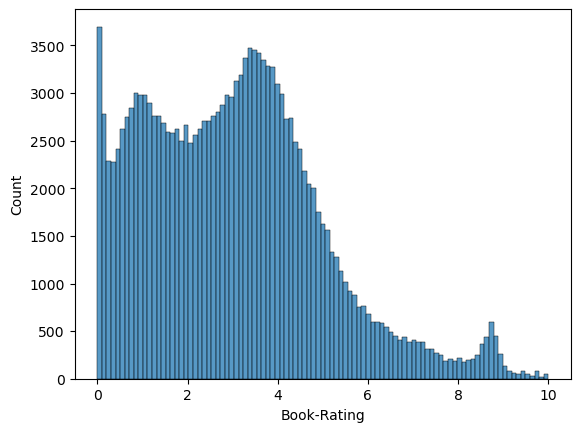

In [27]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [28]:
sub.to_csv('submit_cat+stacking.csv', index=False,encoding="utf-8-sig")